# **Modelling and Evaluation**

## Objectives

* Answer business requirement 2 - tell whether a leaf has powdery mildew or not

## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation
* 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
cwd = os.getcwd()

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [8]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves'

In [13]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

# Section 1

Set Input and Output directories

In [14]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
print(train_path)
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

inputs/cherry-leaves/cherry-leaves/train


In [15]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('An old version is already available, create a new version')
    pass
else:
    os.makedirs(name=file_path)

An old version is already available, create a new version


Set labels 

In [16]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['powdery_mildew', 'healthy']


In [17]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Images in Train, Test and Validation data 

Section 2 content

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




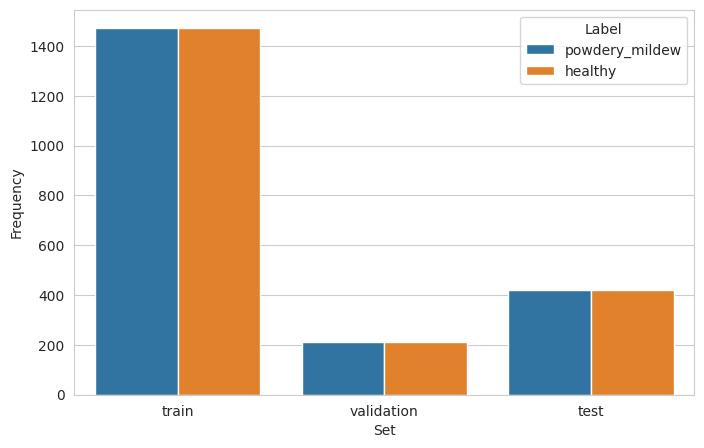

In [18]:
data = {
    'Set':[],
    'Label':[],
    'Frequency':[]
}

folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation 

Image Data Generator 

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-29 14:42:36.581115: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 14:42:53.077122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [21]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [22]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [23]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented images

(20, 256, 256, 3)


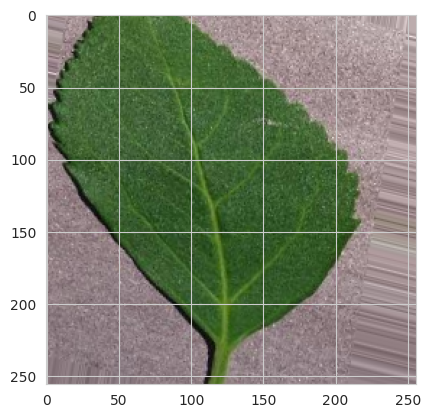

(20, 256, 256, 3)


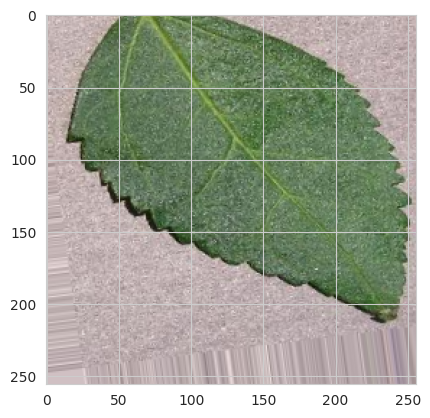

(20, 256, 256, 3)


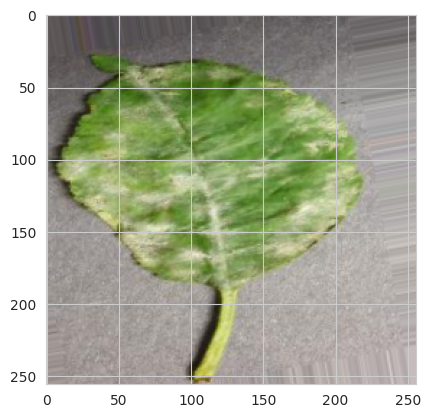

In [24]:
for _ in range (3):
    img, label = next(train_set)
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


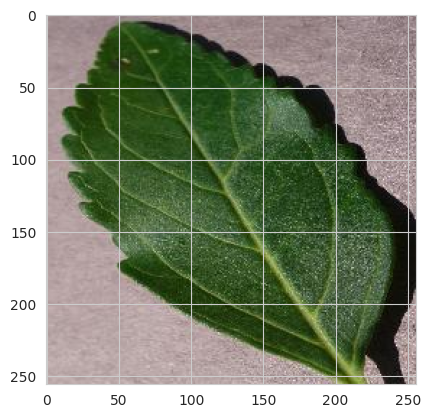

(20, 256, 256, 3)


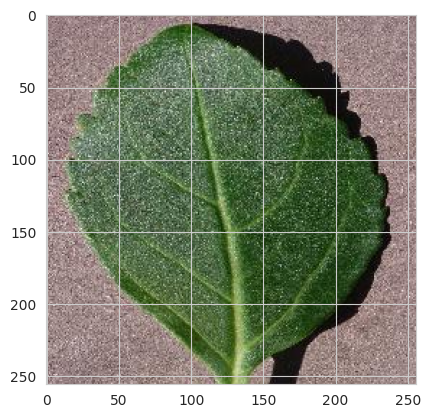

(20, 256, 256, 3)


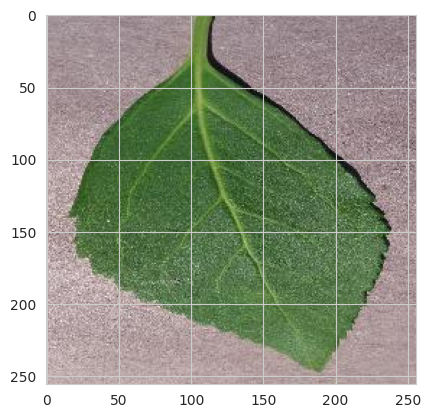

In [25]:
for _ in range (3):
    img, label = next(test_set)
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


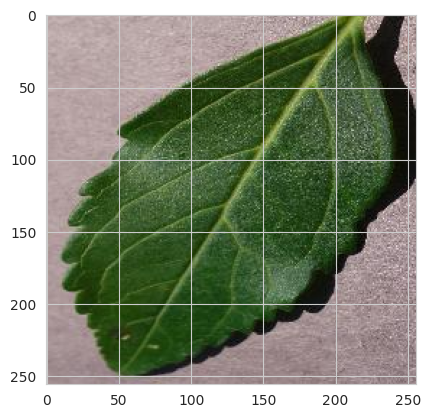

(20, 256, 256, 3)


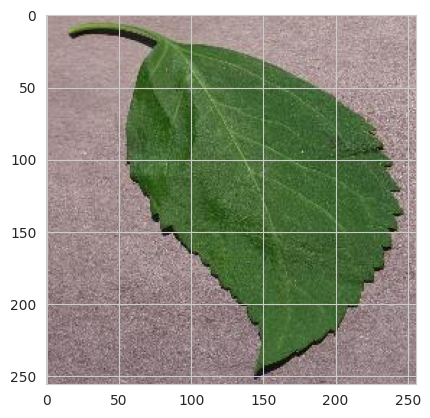

(20, 256, 256, 3)


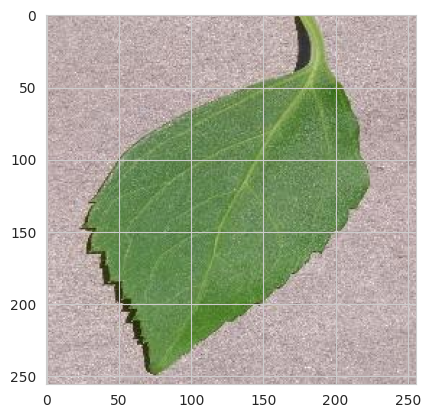

In [26]:
for _ in range (3):
    img, label = next(validation_set)
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

In [27]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
